In [39]:
#import libraries, set seed 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pandas as pd
import numpy as np
import os, random, pickle, sys
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from features import Features

random.seed(19860406)
np.random.seed(19860406)

In [40]:
#Thank you stack overflow: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [41]:
def compute_and_visualize_mse(df, ycol, context, info):        
    
    tr_indices, xv_indices, tr_yhat, xv_yhat = info
    
    '''
    test of model accuracies - Mean Squared Error
    note - we use Mean squared error here, but mean absolute percentage error(MAPE) and 
    mean absolute error (MAE) are also fair possibilities for regression based problems
    '''
    tr_MSE = metrics.mean_squared_error(merged_df[ycol].loc[tr_indices], tr_yhat)
    xv_MSE = metrics.mean_squared_error(merged_df[ycol].loc[xv_indices], xv_yhat)
    
    print('tr MSE {} xval MSE {}'.format(tr_MSE, xv_MSE))

    #preallocate the ERROR field and save for dataviz
    error_col_name = context + "ERROR"
    df[error_col_name] = df.shape[0] * [0.0]
    df.loc[tr_indices, error_col_name] = df[ycol].loc[tr_indices] - tr_yhat
    df.loc[xv_indices, error_col_name] = df[ycol].loc[xv_indices] - xv_yhat

    #plot the errors 
    plt.hist(df[error_col_name].loc[xv_indices], density=True, bins=30)
    plt.ylabel('Frequency')
    plt.xlabel(error_col_name)

    ###### note: our errors should be centered around zero. If the hump in the distribution is not around the zero mark
    ###### or has multiple humps, we have a major problem

In [42]:
def compute_and_visualize_mape(df, ycol, context, info):        
    
    tr_indices, xv_indices, tr_yhat, xv_yhat = info
    
    ##### mean absolute error (MAE) are also fair possibilities for regression based problems
    tr_MAPE = mean_absolute_percentage_error(df[ycol].loc[tr_indices], tr_yhat)
    xv_MAPE = mean_absolute_percentage_error(df[ycol].loc[xv_indices], xv_yhat)

    print('tr MAPE {} xval MAPE {}'.format(tr_MAPE, xv_MAPE))

    #preallocate the ERROR field and save for dataviz
    error_col_name = context + "PERCENTAGE_ERROR"
    df[error_col_name] = merged_df.shape[0] * [0.0]
    df.loc[tr_indices, error_col_name] = merged_df[context + "ERROR"].loc[tr_indices] / tr_yhat
    df.loc[xv_indices, error_col_name] = merged_df[context + "ERROR"].loc[xv_indices] / xv_yhat
    
    #plot the errors 
    plt.hist(df[error_col_name].loc[xv_indices], density=True, bins=30)
    plt.ylabel('Frequency')
    plt.xlabel('Percent Error')

    ###### note: our errors should be centered around zero. If the hump in the distribution is not around the zero mark
    ###### or has multiple humps, we have a major problem

In [43]:
#read in and join the necessary data 
fpath = os.path.join("data", "casetable.psv")
df = pd.read_csv(fpath, 
                 sep = "|", 
                 low_memory=False,
                 dtype = {
                     "Site Address City": str
                 })
df_census = pd.read_csv(os.path.join("data", "census2017.csv"))
merged_df = pd.merge(df, df_census, left_on="Site Zip Code", right_on='ZipCode', how="left")

#make sure the row count did not change
assert df.shape[0] == merged_df.shape[0]

#show number of rows /columns before and after
print("ROWS {} BEFORE MERGE cols {} AFTER MERGE cols {}".format(merged_df.shape[0], df.shape[1], merged_df.shape[1]))

ROWS 170439 BEFORE MERGE cols 30 AFTER MERGE cols 37


In [44]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170439 entries, 0 to 170438
Data columns (total 37 columns):
Parcel Number                          170439 non-null object
Section                                170439 non-null int64
Township                               170439 non-null object
Total Market Value                     170439 non-null float64
Assessed Value                         170439 non-null float64
Total Just Value                       170439 non-null float64
doc acres                              170439 non-null float64
Site Address Number                    170439 non-null int64
Site Address Street Name               170423 non-null object
Site Address Street Type               170097 non-null object
Site Address Unit Number               9566 non-null object
Site Address City                      170422 non-null object
Site Zip Code                          170422 non-null float64
Building Number                        170439 non-null int64
building type code   

In [45]:
'''
building heated area : 0.5532334886630437
quality code : 0.14442706807497316
effective year built : 0.07049727899246086
AdjustedArea_Rooms : 0.052896518905888604
IsAtTheBeach : 0.04718246586953297
Site Zip Code : 
'''

#define data columns 
baseline_features = ["Site Zip Code",
              "quality code",
              "effective year built",
              "building heated area"              
             ]

meta_cols  = ["Parcel Number",
             "Site Address City"]
ycol = "Assessed Value"

In [46]:
#filter out data as necessary
merged_df = merged_df[merged_df['Assessed Value']<500000]
merged_df = merged_df[merged_df['Number Of Bedrooms']<10]
merged_df = merged_df[merged_df['Number Of Bathrooms']<9]

merged_df.fillna(-999,inplace = True)

In [47]:
merged_df[baseline_features].describe(include="all")

,Site Zip Code,quality code,effective year built,building heated area
count,166442.000000,166442.000000,166442.000000,166442.000000
mean,32226.142536,3.129823,1986.333600,1809.836628
std,326.475893,0.531819,18.817768,651.877837
min,-999.000000,1.000000,1888.000000,170.000000
25%,32216.000000,3.000000,1973.000000,1348.000000
50%,32224.000000,3.000000,1989.000000,1692.000000
75%,32246.000000,3.000000,2002.000000,2142.000000
max,32299.000000,6.000000,2018.000000,6754.000000


In [48]:
#create a function to split the data 
def split(df, pct=.7):
    tr, xv = [], []
     
    indices = [x for x in df.index]
    random.shuffle(indices)
 
    for ind in indices:
        if np.random.rand() <= pct:
            tr.append(ind)
        else:
            xv.append(ind)
 
    return tr, xv

In [49]:
#split into test and train. 
tr_indices, xv_indices = split(merged_df)

#verify no nans in the dataset
assert merged_df[baseline_features].isnull().values.any() == False

In [50]:
#fit the model    
rfc = RandomForestRegressor(
        n_estimators = 50, 
        min_samples_leaf = 15)

rfc.fit(merged_df[baseline_features].loc[tr_indices],
        merged_df[ycol].loc[tr_indices])

#fit the predicted values
tr_yhat = rfc.predict(merged_df[baseline_features].loc[tr_indices])
xv_yhat = rfc.predict(merged_df[baseline_features].loc[xv_indices])
       

In [51]:
context = "BASELINE_"

tr MSE 1215095794.3969886 xval MSE 1437070672.3368459


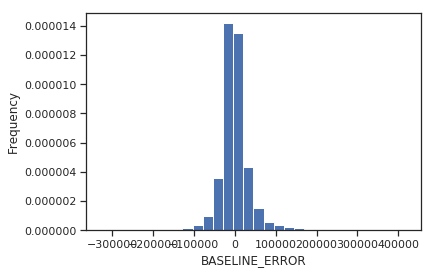

In [52]:
compute_and_visualize_mse(merged_df, ycol, context, (tr_indices, xv_indices, tr_yhat, xv_yhat))

tr MAPE 18.859984606670483 xval MAPE 20.121276932609135


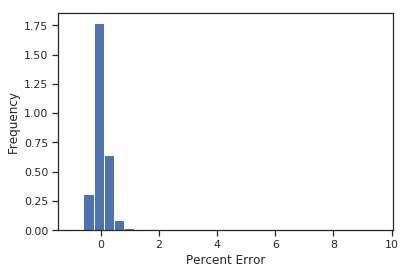

In [53]:
compute_and_visualize_mape(merged_df, ycol, context, (tr_indices, xv_indices, tr_yhat, xv_yhat))

In [54]:
#serialize model
with open(os.path.join(".model", 'model{}.pckl'.format(context)), 'wb') as f:
   pickle.dump(rfc, f,  pickle.HIGHEST_PROTOCOL)

In [55]:
########################################################################################
## Second fit - this time with some engineered features                               ##
########################################################################################

In [56]:
#feature engineering 
features = Features()
merged_df, computed_features = features.compute(merged_df)

#Replace NAs and Infinite Values with -999s 
merged_df.fillna(-999,inplace = True)

In [57]:
#combine the computed features with the baseline features to train a new model
train_cols = computed_features + baseline_features + ["HasPool"]

In [58]:
merged_df[train_cols].describe()

,BedroomToTotalRoomRatio,BathroomToTotalRoomRatio,IsAtTheBeach,AdjustedArea_Rooms,Site Zip Code,quality code,effective year built,building heated area,HasPool
count,166442.000000,166442.000000,166442.000000,1.664420e+05,166442.000000,166442.000000,166442.000000,166442.000000,166442.000000
mean,3.077913,1.895480,0.060057,-9.494281e-17,32226.142536,3.129823,1986.333600,1809.836628,0.125215
std,0.975730,0.753883,0.237593,9.999940e-01,326.475893,0.531819,18.817768,651.877837,0.330963
min,0.000000,0.000000,0.000000,-2.543227e+00,-999.000000,1.000000,1888.000000,170.000000,0.000000
25%,3.000000,2.000000,0.000000,-7.027000e-01,32216.000000,3.000000,1973.000000,1348.000000,0.000000
50%,3.000000,2.000000,0.000000,-1.768353e-01,32224.000000,3.000000,1989.000000,1692.000000,0.000000
75%,4.000000,2.000000,0.000000,5.064831e-01,32246.000000,3.000000,2002.000000,2142.000000,0.000000
max,8.000000,6.000000,1.000000,7.838029e+00,32299.000000,6.000000,2018.000000,6754.000000,1.000000


In [59]:
#fit the model    
rfc = RandomForestRegressor(
        n_estimators = 50, 
        min_samples_leaf = 15)

rfc.fit(merged_df[train_cols].loc[tr_indices],
        merged_df[ycol].loc[tr_indices])

#fit the predicted values
tr_yhat = rfc.predict(merged_df[train_cols].loc[tr_indices])
xv_yhat = rfc.predict(merged_df[train_cols].loc[xv_indices])

In [60]:
context = "COMPUTED_FEATURES_"

tr MSE 1119737675.2269933 xval MSE 1340449386.3841226


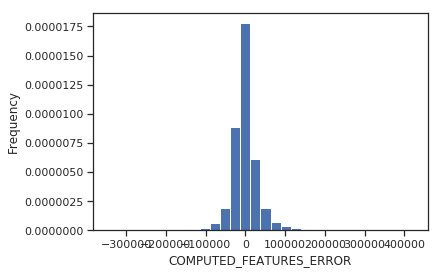

In [61]:
compute_and_visualize_mse(merged_df,  ycol, context, (tr_indices, xv_indices, tr_yhat, xv_yhat))

tr MAPE 17.860771246463532 xval MAPE 19.120718894617468


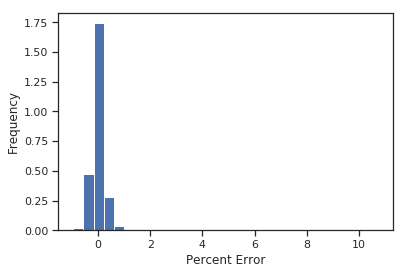

In [62]:
compute_and_visualize_mape(merged_df, ycol, context, (tr_indices, xv_indices, tr_yhat, xv_yhat))

In [63]:
########################################################################################
## Add feature importance to see impact of feature on model                           ##
########################################################################################
fi = rfc.feature_importances_

#sort rank the feature importance creating a tuple of featurename and score
ordered_features = sorted(zip(train_cols, fi), key=lambda x: x[1], reverse=True)
for of in ordered_features:
    featurename = of[0]
    score       = of[1]
    print (featurename,":",score)

building heated area : 0.5688234103410081
quality code : 0.14835889147826328
effective year built : 0.09021923262508912
Site Zip Code : 0.061414304074526915
AdjustedArea_Rooms : 0.05960411205757022
IsAtTheBeach : 0.05205609541077425
HasPool : 0.008897232777135125
BedroomToTotalRoomRatio : 0.005923391705106724
BathroomToTotalRoomRatio : 0.004703329530526325


In [64]:
#serialize model
with open(os.path.join(".model", 'model{}.pckl'.format(context)), 'wb') as f:
   pickle.dump(rfc, f,  pickle.HIGHEST_PROTOCOL)